## 0. Paquetes

In [1]:
import numpy as np
import pandas as pd
import random
from pickle import dump
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Reshape, Conv1D
from keras.preprocessing.sequence import TimeseriesGenerator 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
from numpy import array
from sklearn.impute import KNNImputer
import datetime
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
assert tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import os


In [4]:
## FIX RANDOM PARAMETERS

seed_value = 1820

os.environ['PYTHONHASHSEED']=str(seed_value)

# PYTHON GENERATOR
import random
random.seed(seed_value)

# NUMPY
np.random.seed(seed_value)

# TENSOR FLOW
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

#KERAS
tf.keras.utils.set_random_seed(seed_value)

## 1. Importar y pre-procesar bases

In [ ]:
# https://gist.github.com/rohithteja/821935e7c3c690bb424ab8e1edc59dec
# https://stackoverflow.com/questions/72685216/has-anyone-implemented-a-optuna-hyperparameter-optimization-for-a-pytorch-lstm

In [10]:
########## Parámetros
data_input = "OUTPUT4_FINALDB.xlsx"
date_column = "date"
target_id = "q"

########## Leer dataframe
df = pd.read_excel(data_input) 
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

########## Dataframe univariado para el modelo
dYu = df.copy()[["q"]] #
dYu = dYu[dYu.q<3224477.37] #ELIMINAR OUTLIERS

#SEMANA
Yu = dYu.iloc[0:-1] #No teneren cuenta el último dato es un outlier
Yu['date_week'] = Yu.index.to_period('W')
Yu['date_week'] = Yu['date_week'].apply(lambda x: x.start_time)
Yu_d = Yu.copy()
number_days = Yu.groupby("date_week").count().reset_index()
number_days.set_index("date_week", inplace=True)

# number_days.columns = ["date_week", "number_of_days"]

Yu = Yu.groupby("date_week").sum().reset_index()
# Yu = pd.merge(Yu, number_days, "left", "date_week")
Yu.set_index("date_week", inplace=True)

#NUMERO DE DÍAS DE LA SEMANA + TRAER A NIVELES
Q = Yu.iloc[:-1].copy() #DATAFRAME UTIL PARA MÁS TRAER A NIVELES

#CAMBIO PORCENTIAL

N = Yu.copy()
Yu = Yu.pct_change()*100
Yu.loc[Yu[Yu.q>200].index[0], "q"] = 100
Yu = Yu[(number_days.q>6)]
# Yu = Yu.iloc[:-1]
Yu = Yu.dropna()
# Yu = Yu[["q"]]


<ipython-input-10-1cba342f0283>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yu['date_week'] = Yu.index.to_period('W')
<ipython-input-10-1cba342f0283>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yu['date_week'] = Yu['date_week'].apply(lambda x: x.start_time)


## 2. Modelos univariado

### 2.1 Split and arrange data

In [4]:
# Parametros generales
Yu = Yu[["q"]] # PRESERVE Y
train_size  = 0.96  # % TRAIN


# Yu = Yu[["q"]].iloc[0:50] # PRESERVE Y
# train_size  = 0.80  # % TRAIN


# train_size  = 0.8  # % TRAIN
val_size    = 1 - train_size  # % VAL
n_lag       = 7     # LAGS
n_features  = Yu.shape[1]     # FEATURES -> SOLAMENTE UNO
MAX_EPOCHS  = 100    # EPOCAS
len_batch   = 1  # BATCHSIZE <--PREGUNTAR

#### SPLIT DATA
n = len(Yu)
train = Yu[0:int(n * train_size)] 
val = Yu[int(n * train_size):int(n*(train_size + val_size))]
test = Yu[int(n*(train_size + val_size)):]

print("Observaciones:")
print("Total:", len(Yu))
print("Entrenamiento:", len(train), f"({round(len(train)/len(Yu)*100,1)}%)")
print("Validación:", len(val), f"({round(len(val)/len(Yu)*100,1)}%)")
print("Prueba:", len(test), f"({round(len(test)/len(Yu)*100,1)}%)", "\n")

# ESTANDARIZAR
scaler_y = StandardScaler()
scaler_y.fit(train)
Ys_train = scaler_y.transform(train)
Ys_val = scaler_y.transform(val)
Ys_all = scaler_y.transform(Yu)


# UNIVARIATE SERIE
ts_trai_uni = TimeseriesGenerator(Ys_train, Ys_train, length=n_lag, batch_size=len_batch, shuffle= False)
ts_vali_uni = TimeseriesGenerator(Ys_val, Ys_val, length=n_lag, batch_size=len_batch, shuffle= False)
ts_all_uni = TimeseriesGenerator(Ys_all, Ys_all, length=n_lag, batch_size=len_batch, shuffle= False)

# DICT WITH PERFORMANCES
vali_performance = {}
trai_performance= {}

val.iloc[0]

Observaciones:
Total: 180
Entrenamiento: 172 (95.6%)
Validación: 8 (4.4%)
Prueba: 0 (0.0%) 



q   -13.750714
Name: 2022-05-02 00:00:00, dtype: float64

### 2.2 Model building

#### Primer modelo (-> learnin rate)

In [6]:
#### Parametros

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

# param_opt = {
#     "learning_rate": max_lr,
#     "beta_1" : 0.9,
#     "beta_2" : 0.999,
#     "epsilon": 1e-07}

optimizer_adam = tf.optimizers.Adam()

#### Modelo 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
model.add(Dense(30))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.Huber(), 
        optimizer=optimizer_adam, 
        metrics=metrica)


#### Parametro a optimizar
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 20**(epoch / 20))

#### Model building
history = model.fit(ts_trai_uni, 
    validation_data = ts_vali_uni,  
    epochs=MAX_EPOCHS, 
    verbose=0,
    callbacks = [lr_schedule])

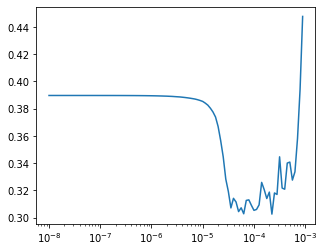

In [10]:
#OPTIMUM LEARNING RATE
lrs = 1e-8 * (10 ** (np.arange(len(history.history["loss"])) / 20))
y_loss = history.history["loss"]
index_minimum_loss = y_loss.index(min(y_loss))
max_lr = lrs[index_minimum_loss]

fig, ax =plt.subplots(1,1, figsize=(5, 4), sharex = False)
plt.semilogx(lrs[0:], y_loss[0:])

### 2.3 Hiperparametización

#### Learning rate + grilla beta1

In [11]:
#### Parametros

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

optimizer_adam = tf.optimizers.Adam()

b1_schedule = [0.2, 0.3, 0.5, 0.6, 0.7, 0.6, 0.7, 0.8, 0.9]

b1_score = []

for i in b1_schedule:

    param_opt = {
        "learning_rate": max_lr,
        "beta_1" : i,
        "beta_2" : 0.999,
        "epsilon": 1e-07}
    #### Modelo 
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
    model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
    model.add(Dense(30))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.Huber(), 
            optimizer=optimizer_adam, 
            metrics=metrica)


    #### Model building
    history = model.fit(ts_trai_uni, 
        validation_data = ts_vali_uni,  
        epochs=MAX_EPOCHS, 
        verbose=0)

    score = scaler_y.inverse_transform(array(model.evaluate(ts_vali_uni, verbose = 0)[1]).reshape(-1,1))
    b1_score.append(score)

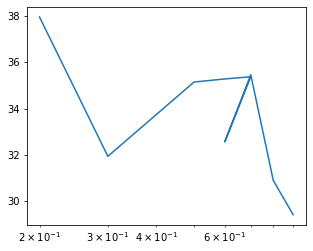

In [12]:
b1_schedule
for i in range(len(b1_score)):
    b1_score[i] = b1_score[i][0][0]

index_minimum_b1 = b1_score.index(min(b1_score))
max_b1 = b1_schedule[index_minimum_b1]

fig, ax =plt.subplots(1,1, figsize=(5, 4), sharex = False)
plt.semilogx(b1_schedule, b1_score)

#### Learning rate + beta1 + grilla beta2

In [13]:
#### Parametros

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

optimizer_adam = tf.optimizers.Adam()

b2_schedule = [0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 0.9999]

b2_score = []

for i in b2_schedule:

    param_opt = {
        "learning_rate": max_lr,
        "beta_1" : max_b1,
        "beta_2" : i,
        "epsilon": 1e-07}
    #### Modelo 
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
    model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
    model.add(Dense(30))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.Huber(), 
            optimizer=optimizer_adam, 
            metrics=metrica)


    #### Model building
    history = model.fit(ts_trai_uni, 
        validation_data = ts_vali_uni,  
        epochs=MAX_EPOCHS, 
        verbose=0)

    score = scaler_y.inverse_transform(array(model.evaluate(ts_vali_uni, verbose = 0)[1]).reshape(-1,1))
    b2_score.append(score)

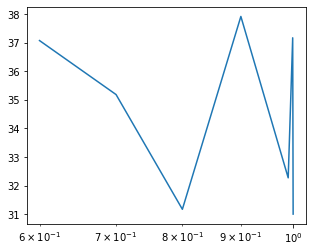

In [14]:
b2_schedule
for i in range(len(b2_score)):
    b2_score[i] = b2_score[i][0][0]

index_minimum_b2 = b2_score.index(min(b2_score))
max_b2 = b2_schedule[index_minimum_b2]

fig, ax =plt.subplots(1,1, figsize=(5, 4), sharex = False)
plt.semilogx(b2_schedule, b2_score)

#### Learning rate + beta1 + beta2 + grilla epsilon

In [15]:
#### Parametros

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

optimizer_adam = tf.optimizers.Adam()

# e_schedule = [1e-001, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08]
e_schedule = [1e-04, 1e-05, 1e-06, 1e-07, 1e-08]

e_score = []

for i in e_schedule:

    param_opt = {
        "learning_rate": max_lr,
        "beta_1" : max_b1,
        "beta_2" : max_b2,
        "epsilon": 1e-07}
    #### Modelo 
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
    model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
    model.add(Dense(30))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.Huber(), 
            optimizer=optimizer_adam, 
            metrics=metrica)


    #### Model building
    history = model.fit(ts_trai_uni, 
        validation_data = ts_vali_uni,  
        epochs=MAX_EPOCHS, 
        verbose=0)

    score = scaler_y.inverse_transform(array(model.evaluate(ts_vali_uni, verbose = 0)[1]).reshape(-1,1))
    e_score.append(score)

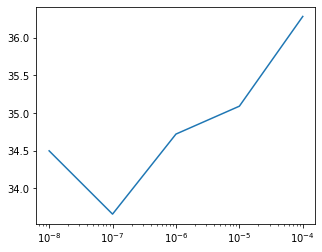

In [16]:
e_schedule
for i in range(len(e_score)):
    e_score[i] = e_score[i][0][0]

index_minimum_e = e_score.index(min(e_score))
max_e = e_schedule[index_minimum_e]

fig, ax =plt.subplots(1,1, figsize=(5, 4), sharex = False)
plt.semilogx(e_schedule, e_score)

#### Modelo óptimo

In [5]:
max_lr, max_b1, max_b2, max_e = 0.00022387211385683378, 0.9, 0.9999, 1e-07

In [ ]:
seed_value = 1820

os.environ['PYTHONHASHSEED']=str(seed_value)

# PYTHON GENERATOR
import random
random.seed(seed_value)

# NUMPY
np.random.seed(seed_value)

# TENSOR FLOW
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

#KERAS
tf.keras.utils.set_random_seed(seed_value)

In [7]:
import os

In [8]:
#### Parametros

tf.random.set_seed(2)
os.environ['PYTHONHASHSEED']=str(2)
tf.keras.utils.set_random_seed(2)

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

param_opt = {
    "learning_rate": max_lr,
    "beta_1" : max_b1,
    "beta_2" : max_b2,
    "epsilon": max_e}

optimizer_adam = tf.optimizers.Adam()

#### Modelo 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
model.add(Dense(30))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.Huber(), 
        optimizer=optimizer_adam, 
        metrics=metrica)


#### Model building
history = model.fit(ts_trai_uni, 
    validation_data = ts_vali_uni,  
    epochs=MAX_EPOCHS, 
    verbose=0,
    callbacks = [])

## 3. Desempeño modelo

#### 3.1 Prediccion 1-paso y n-pasos fuera de entrenamiento

In [9]:
# PREDICCIÓN N (TRAIN) PASOS

trai_performance["UNIV"] = scaler_y.inverse_transform(array(model.evaluate(ts_trai_uni, verbose = 0)[1]).reshape(-1,1))
vali_performance["UNIV"] = scaler_y.inverse_transform(array(model.evaluate(ts_vali_uni, verbose = 0)[1]).reshape(-1,1))
# PRIMER OUTPUT: LOSS (MSE) | # SEGUNDO OUTPUT: MAE | # PRIMER OUTPUT: MAE PERCENTAGE | # SEGUNDO OUTPUT: LOSS (MSE)
print(trai_performance, vali_performance)


# PREDICCIÓN
X_ini = Ys_all[-(len(Ys_val) + n_lag): ][:n_lag] #CREAR ARREGLO DE LOS (N_LAGS) VALORES PREVIOS 
X_ini = X_ini.reshape(n_features, n_lag, n_features)

for i in range(len(Ys_val)):
    Y_pred = model.predict(X_ini[:, i : n_lag+i+1, :], verbose=0)
    X_ini = np.append(X_ini, Y_pred).reshape(n_features, len(X_ini[0])+1, n_features)

X_ini = X_ini[0][n_lag:]

pred_p = X_ini.copy()

pred_p = scaler_y.inverse_transform(pred_p)
b = np.empty((len(Ys_train),1,))
b[:] = np.nan
pred_p = np.concatenate((b, pred_p), axis = 0)
pred_p = pred_p.reshape(-1)

#PREDICCIÓN EN ALL
yhat_all = model.predict(ts_all_uni, verbose=0)
yhat_all_level = scaler_y.inverse_transform(yhat_all)

a = np.empty((n_lag,1,))
a[:] = np.nan

# OBSERVADO EN ALL
yhat_all_level = np.concatenate((a, yhat_all_level),axis = 0)
yobs_test_level = scaler_y.inverse_transform(Ys_all)

# DATAFRAME
preds = pd.DataFrame(zip( yobs_test_level.reshape(len(yobs_test_level)), yhat_all_level.reshape(len(yhat_all_level)), pred_p),
            index = Yu.index,
            columns = ["OBSERVADO", "PREDICHO_ONESTEP", "PREDICHO_PRED"])

{'UNIV': array([[16.30785579]])} {'UNIV': array([[13.01606082]])}


In [ ]:
{'UNIV': array([[16.30785579]])} {'UNIV': array([[13.01606082]])}

¿Cómo luce?

<ipython-input-60-c8bff040392d>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


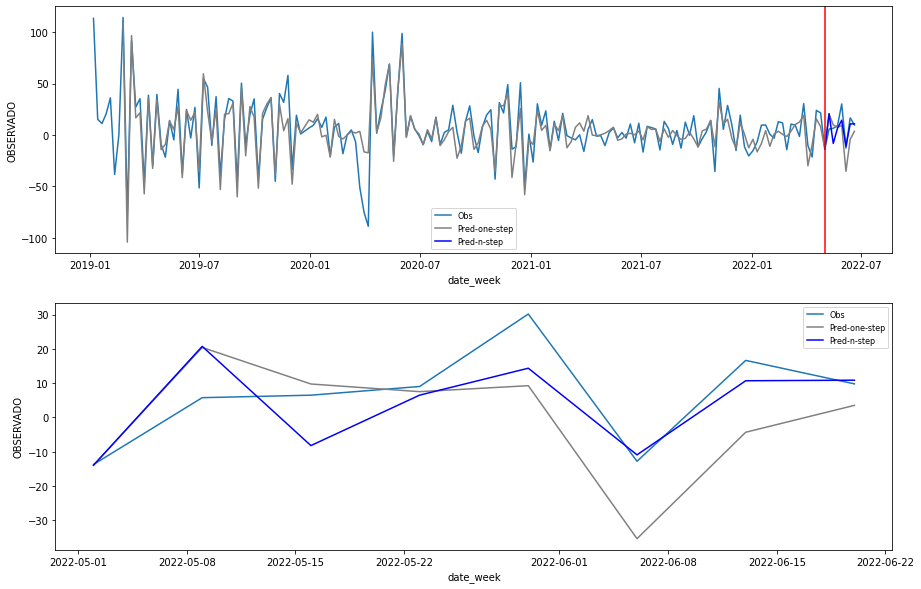

In [60]:
# VISUALIZAR
fig, ax =plt.subplots(2,1, figsize=(15, 10), sharex = False)

#PRIMERA GRÁFICA
sns.lineplot(x=preds.index, y=preds.OBSERVADO, ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_ONESTEP, color = "gray", ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_PRED, color = "blue", ax = ax[0])

ax[0].axvline(x=preds.index[int(n * train_size)], color='red')
ax[0].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[0].axis(ymin= 20015.12, ymax= 970278.39)


#SEGUNDA GRÁFICA
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.OBSERVADO[int(n * train_size):][0:30], ax = ax[1])
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.PREDICHO_ONESTEP[int(n * train_size):][0:30], color = "gray", ax = ax[1])
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.PREDICHO_PRED[int(n * train_size):][0:30], color = "blue", ax = ax[1])

ax[1].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[1].axis(ymin= 320015.12, ymax= 970278.39)


fig.show()

In [52]:
from tensorflow.keras.models import load_model

In [5]:
from tensorflow.keras.models import load_model
import joblib

In [65]:
# Serialize the model to JSON
model_json = model.to_json()
with open("MODELO/modelVF.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights("MODELO/modelW_VF.h5")
model.save("MODELO/modelVF.h5")

# Save the scalar used in train to a pickle file
# dump(scaler_y, open("MODELO/scalerVF.pkl", "wb"))
joblib.dump(scaler_y, "MODELO/scalerVF.gz")


# Save model helpers for prediction
model_helpers = {
    "n_inputs": n_features
}
dump(model_helpers, open("MODELO/model_helpersVF.pkl", "wb"))

In [7]:

my_scaler = joblib.load("MODELO/modelo_02_07_2023/scalerVF.gz") #SCALER
model_load = load_model("MODELO/modelo_02_07_2023/modelVF.h5", compile=False) #MODELO
lags = model_load.input_shape[1]

In [51]:
N.to_excel("DATA.xlsx")

In [49]:
def pred(df, model, scalerm, periodos_pred = 8):

    """
    Forecast recursive prediction using Keras model. 
    
    Parameters
    ---------------
    df: Dataframe object of observed values with index as date and one column with data.
    model: Pretrained model used for predition.
    scalerm: Scaler used during training.
    periodos_pred: number periods (weeks) a predecir
    """

    pronostico_niveles = [df.iloc[-1][0]]
    
    #Pre-procesamiento de los datos
    lags = model.input_shape[1] #numero_lags
    df = df.pct_change()*100
    df = df.dropna()
    Ys_all = scalerm.transform(df) #transformar la serie

    #Reshap de la serie para la lectura del modeo
    Y_ph = Ys_all[-lags:] 
    Y_ph = Y_ph.reshape(1, lags, 1)

    #Rango de fechas (semanas)
    week_1 = df.index[-1] + datetime.timedelta(days=7)
    week_f = week_1 + datetime.timedelta(weeks=periodos_pred)
    range_date = pd.date_range(start= week_1, end= week_f, freq = "W-MON")

    #Predicción
    for i in range(len(range_date)):
        Y_pred = model.predict(Y_ph[:, i : lags+i+1, :], verbose=0)
        Y_ph = np.append(Y_ph, Y_pred).reshape(1, len(Y_ph[0])+1, 1)

    #Re-escalar (traer a cambios porcentuales)
    Y_ph = scalerm.inverse_transform(Y_ph[0][lags:])
    pronostico_variacion = Y_ph.reshape(len(Y_ph))
    

    #Traer a niveles
    for i in range(len(pronostico_variacion)):
        ynsetp = (pronostico_variacion[i]/100 + 1)*pronostico_niveles[i]
        pronostico_niveles.append(ynsetp)

    #Predicciones y eje (fecha)
    predictions = pronostico_niveles[1:]
    prediction_xaxis = []

    for i in range(len(range_date)):
        k = str(range_date[i])[0:10]
        prediction_xaxis.append(k)
        

    return dict(zip(prediction_xaxis, list(predictions)))
    # return predictions

In [50]:
pred(N, model_load, my_scaler, periodos_pred = 30)

{'2022-07-04': 2718431.1667368226,
 '2022-07-11': 3065748.1827294766,
 '2022-07-18': 3835992.6069952906,
 '2022-07-25': 4369671.107698244,
 '2022-08-01': 4120437.339360842,
 '2022-08-08': 4718506.680280455,
 '2022-08-15': 5265300.527722773,
 '2022-08-22': 4135935.5788519867,
 '2022-08-29': 3619882.3412898565,
 '2022-09-05': 3518691.99291399,
 '2022-09-12': 3610188.737644151,
 '2022-09-19': 3815467.3893147414,
 '2022-09-26': 3405134.7279803636,
 '2022-10-03': 3331087.890696185,
 '2022-10-10': 3461955.5794732715,
 '2022-10-17': 3489598.212587595,
 '2022-10-24': 3523227.2323069656,
 '2022-10-31': 3501232.5172194648,
 '2022-11-07': 3394529.8905864167,
 '2022-11-14': 3450824.3591633667,
 '2022-11-21': 3551472.531185982,
 '2022-11-28': 3527770.779762879,
 '2022-12-05': 3604278.0496848053,
 '2022-12-12': 3670085.941430613,
 '2022-12-19': 3716727.9067319725,
 '2022-12-26': 3775869.2814459493,
 '2023-01-02': 3884284.2538373084,
 '2023-01-09': 3908422.017818364,
 '2023-01-16': 4007498.8903462226

#### 3.2 Predicción por semana en niveles, dentro y fuera de muestra

In [75]:
Y_ph = Ys_all[-n_lag:] #FOOD INICIAL
Y_ph = Y_ph.reshape(n_features, n_lag, n_features)

#SEMANA A PREDECIR ADELANTE
week_1 = Yu.index[-1] + datetime.timedelta(days=7)
# week_1 = '2022-06-27'
week_f = '2023-01-02'
range_date = pd.date_range(start= week_1, end= week_f, freq = "W-MON")



for i in range(len(range_date)):
    Y_pred = model_load.predict(Y_ph[:, i : n_lag+i+1, :], verbose=0)
    Y_ph = np.append(Y_ph, Y_pred).reshape(n_features, len(Y_ph[0])+1, n_features)

Y_ph = Y_ph[0][n_lag:]

pred_yph = pd.DataFrame(scaler_y.inverse_transform(Y_ph), columns = ["FUERA_MUESTRA"], index = range_date)

In [77]:
H = Q.copy()
H.columns = ["NIVELES"]

PREDICCIONES = pd.concat([H, preds, pred_yph], axis=1)
PREDICCIONES["NIVELES_1"] = PREDICCIONES["NIVELES"].shift(1)


PREDICCIONES["ONE_STEP_LEVELS"]  = PREDICCIONES["NIVELES_1"] * (1 + (PREDICCIONES["PREDICHO_ONESTEP"]/100))
PREDICCIONES["N_STEP_LEVELS"]  = PREDICCIONES["NIVELES_1"] * (1 + (PREDICCIONES["PREDICHO_PRED"]/100))

PREDICCIONES["FUERA_MUESTRA_LEVELS"] = PREDICCIONES["NIVELES"]
rango_fuera = range((len(PREDICCIONES) - len(range_date)), len(PREDICCIONES)) 
for i in rango_fuera:
    PREDICCIONES.iloc[i, -1] = PREDICCIONES.iloc[i-1, -1] * (1+PREDICCIONES.iloc[i, 4]/100)

In [78]:
PREDICCIONES.loc[PREDICCIONES[PREDICCIONES.NIVELES>0].index, "FUERA_MUESTRA_LEVELS"] = np.nan

In [79]:
PREDICCIONES

,NIVELES,OBSERVADO,PREDICHO_ONESTEP,PREDICHO_PRED,FUERA_MUESTRA,NIVELES_1,ONE_STEP_LEVELS,N_STEP_LEVELS,FUERA_MUESTRA_LEVELS
2018-12-31,114975.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,245382.83,113.420951,NaN,NaN,NaN,114975.98,NaN,NaN,NaN
2019-01-14,282671.93,15.196296,NaN,NaN,NaN,245382.83,NaN,NaN,NaN
2019-01-21,314060.29,11.104166,NaN,NaN,NaN,282671.93,NaN,NaN,NaN
2019-01-28,378816.41,20.619009,NaN,NaN,NaN,314060.29,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-05,NaN,NaN,NaN,NaN,-5.862140,NaN,NaN,NaN,6.140309e+06
2022-12-12,NaN,NaN,NaN,NaN,-0.782998,NaN,NaN,NaN,6.092230e+06
2022-12-19,NaN,NaN,NaN,NaN,2.266350,NaN,NaN,NaN,6.230302e+06
2022-12-26,NaN,NaN,NaN,NaN,1.950228,NaN,NaN,NaN,6.351807e+06


In [81]:
PREDICCIONES["MES"] =  PREDICCIONES.index.strftime('%Y%m')
metricas = ["ONE_STEP_LEVELS", "N_STEP_LEVELS"] 

# PREDICCIONES.to_excel("OUTPUT5_PREDICCIONES_NIVELES_SEMANAL.xlsx")

In [87]:
PRED_MENSUAL = PREDICCIONES.groupby("MES")["NIVELES", "ONE_STEP_LEVELS", "N_STEP_LEVELS", "FUERA_MUESTRA_LEVELS"].sum()
PRED_MENSUAL.to_excel("OUTPUT6_PREDICCIONES_NIVELES_MENSUAL_K.xlsx")

<ipython-input-87-4769292cd01a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  PRED_MENSUAL = PREDICCIONES.groupby("MES")["NIVELES", "ONE_STEP_LEVELS", "N_STEP_LEVELS", "FUERA_MUESTRA_LEVELS"].sum()


#### 3.3 Métricas mes a mes

In [83]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

In [84]:
tpredic = []
tmes = []
tmae = []
tmape = []
trmse = []
tporcentaje = []

for predi in metricas:
    df_pred = PREDICCIONES[PREDICCIONES[predi].notna()][[predi, "NIVELES", "MES"]]
    for mes in df_pred.MES.unique():
        df_pred_mes = df_pred[df_pred.MES == mes]
        MAE = mae(df_pred_mes.NIVELES	, df_pred_mes[predi])
        MAPE = mape(df_pred_mes.NIVELES	, df_pred_mes[predi])
        RMSE = np.sqrt(mse(df_pred_mes.NIVELES	, df_pred_mes[predi]))
        PORCENTAJE = (df_pred[df_pred.MES == mes][predi].sum()/df_pred[df_pred.MES == mes].NIVELES.sum())

        tpredic.append(predi)
        tmes.append(mes) 
        tmae.append(MAE) 
        tmape.append(MAPE)
        trmse.append(RMSE)
        tporcentaje.append(PORCENTAJE)

In [86]:
METRICAS_MES = pd.DataFrame(zip(tpredic, tmes, tmae, tmape, trmse, tporcentaje),
        columns =  ["Predicción", "Mes", "MAE", "MAPE", "RMSE", "RAZÓN Yh/Yo"])

METRICAS_MES.to_excel("OUTPUTX_METRICAS_NIVELES_MESL_K.xlsx")

## 4. Función modelo

In [71]:
########## Parámetros
data_input = "OUTPUT4_FINALDB.xlsx"
date_column = "date"
target_id = "q"

########## Leer dataframe
df = pd.read_excel(data_input) 
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

########## Dataframe univariado para el modelo
dYu = df.copy()[["q"]] # LLEVARNOS FESTIVOS
dYu = dYu[dYu.q<3224477.37] #ELIMINAR OUTLIERS

#SEMANA
Yu = dYu.iloc[0:-1]
Yu['date_week'] = Yu.index.to_period('W')
Yu['date_week'] = Yu['date_week'].apply(lambda x: x.start_time)
Yu_d = Yu.copy()
number_days = Yu.groupby("date_week").count().reset_index()
number_days.set_index("date_week", inplace=True)

# number_days.columns = ["date_week", "number_of_days"]

Yu = Yu.groupby("date_week").sum().reset_index()
# Yu = pd.merge(Yu, number_days, "left", "date_week")
Yu.set_index("date_week", inplace=True)

#NUMERO DE DÍAS DE LA SEMANA + TRAER A NIVELES
Q = Yu.iloc[:-1].copy() #DATAFRAME UTIL PARA MÁS TRAER A NIVELES

#CAMBIO PORCENTIAL

Yu = Yu.pct_change()*100
Yu.loc[Yu[Yu.q>200].index[0], "q"] = 100
Yu = Yu[(number_days.q>6)]
# Yu = Yu.iloc[:-1]
Yu = Yu.dropna()
# Yu = Yu[["q"]]

<ipython-input-71-839df13b66bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yu['date_week'] = Yu.index.to_period('W')
<ipython-input-71-839df13b66bb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yu['date_week'] = Yu['date_week'].apply(lambda x: x.start_time)


In [85]:

def model_build(data_semanal):


    # Parametros generales
    data_semanal = data_semanal[["q"]] # PRESERVE Y
    train_size  = 0.96  # % TRAIN
    # train_size  = 0.8  # % TRAIN
    val_size    = 1 - train_size  # % VAL
    n_lag       = 7     # LAGS
    n_features  = data_semanal.shape[1]     # FEATURES -> SOLAMENTE UNO
    MAX_EPOCHS  = 100    # EPOCAS
    len_batch   = 1  # BATCHSIZE <--PREGUNTAR

    #### SPLIT DATA
    n = len(data_semanal)
    train = data_semanal[0:int(n * train_size)] 
    val = data_semanal[int(n * train_size):int(n*(train_size + val_size))]
    test = data_semanal[int(n*(train_size + val_size)):]


    # ESTANDARIZAR
    scaler_y = StandardScaler()
    scaler_y.fit(train)
    Ys_train = scaler_y.transform(train)
    Ys_val = scaler_y.transform(val)
    Ys_all = scaler_y.transform(data_semanal)


    # UNIVARIATE SERIE
    ts_trai_uni = TimeseriesGenerator(Ys_train, Ys_train, length=n_lag, batch_size=len_batch, shuffle= False)
    ts_vali_uni = TimeseriesGenerator(Ys_val, Ys_val, length=n_lag, batch_size=len_batch, shuffle= False)
    ts_all_uni = TimeseriesGenerator(Ys_all, Ys_all, length=n_lag, batch_size=len_batch, shuffle= False)


    #### Parametros

    max_lr, max_b1, max_b2, max_e = 0.00022387211385683378, 0.9, 0.9999, 1e-07

    #Early stop
    paciencia = 20
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

    #Model parameters
    perdida = tf.losses.MeanSquaredError()
    metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

    #Optimizer

    param_opt = {
        "learning_rate": max_lr,
        "beta_1" : max_b1,
        "beta_2" : max_b2,
        "epsilon": max_e}

    optimizer_adam = tf.optimizers.Adam()

    #### Modelo 
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
    model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
    model.add(Dense(30))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.Huber(), 
            optimizer=optimizer_adam, 
            metrics=metrica)


    #### Model building
    history = model.fit(ts_trai_uni, 
        validation_data = ts_vali_uni,  
        epochs=MAX_EPOCHS, 
        verbose=0,
        callbacks = [])
    
    return model
        

In [86]:
modelo_usar = model_build(Yu)

In [11]:
def pred(model, periodos_pred = 10):
    Y_ph = Ys_all[-n_lag:] #FOOD INICIAL
    Y_ph = Y_ph.reshape(n_features, n_lag, n_features)

    week_1 = Yu.index[-1] + datetime.timedelta(days=7)
    week_f = week_1 + datetime.timedelta(weeks=periodos_pred)
    range_date = pd.date_range(start= week_1, end= week_f, freq = "W-MON")



    for i in range(len(range_date)):
        Y_pred = modelo_usar.predict(Y_ph[:, i : n_lag+i+1, :], verbose=0)
        Y_ph = np.append(Y_ph, Y_pred).reshape(n_features, len(Y_ph[0])+1, n_features)

    Y_ph = scaler_y.inverse_transform(Y_ph[0][n_lag:])


    pronostico_variacion = Y_ph.reshape(len(Y_ph))
    pronostico_niveles = [Q.iloc[-1][0]]

    for i in range(len(pronostico_variacion)):
        ynsetp = (pronostico_variacion[i]/100 + 1)*pronostico_niveles[i]
        pronostico_niveles.append(ynsetp)
        

    pred_yph1 = pd.DataFrame(pronostico_niveles[1:], columns = ["FUERA_MUESTRA"], index = range_date)
    return pred_yph1

In [12]:
#RETORNAR JSON CON DOS ARREGLOS

In [13]:
pred(modelo_usar, 30)

NameError: name 'modelo_usar' is not defined